# Exploratory data analysis

<a name="content"> </a>
## Table of contents
---

* [Dataset summary and EDA](#step1)

Dataset summary with basic statistics and respective plots;

* [Hypotheses testing](#step2)

Testing statistical hypotheses


* [Inferences](#step8)

In [1]:
from collections import Counter
from datetime import datetime
import warnings
from tqdm import tqdm
import os
import pingouin as pg
from mycolorpy import colorlist as mcp

import pandas as pd
import numpy as np

import scipy.stats as sts
from scipy.stats import probplot, kstest, shapiro
import statsmodels.api as sm
from statsmodels.stats import weightstats

import matplotlib.gridspec as gridspec
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px

from sklearn.pipeline import make_pipeline
from sklearn.decomposition import PCA
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestRegressor

from nltk.stem import WordNetLemmatizer
from nltk.tokenize import word_tokenize

warnings.filterwarnings('ignore')

In [4]:
DATA_PATH = "./scrapped_data"
SCRAPPED_DATA_PATH = os.path.join(DATA_PATH, "scrapped_data_topics.csv")
MOST_COMMON_COUNT = 100

## Preparation stage

In [5]:
df = pd.read_csv(SCRAPPED_DATA_PATH, parse_dates=["date"])
print(df.shape)
df.sample(3)

(9933, 30)


title           publication  \
8943                         Gradient Descent in Python  Towards Data Science   
6578   Complete Guide to Data Visualization with Python  Towards Data Science   
3696  3 Quick Tips for Great Writing from an Audiobo...           The Startup   

                                                   link  \
8943  https://towardsdatascience.com/gradient-descen...   
6578  https://towardsdatascience.com/complete-guide-...   
3696  https://medium.com/swlh/3-quick-tips-for-great...   

                       author  followers  reading_time  n_words  \
8943            Sagar Mainkar        212             7     1380   
6578  Albert Sanchez Lafuente        520            12     1811   
3696          Alex S. Freeman         87             5     1097   

                                              pure_text       date  responses  \
8943  When you venture into machine learning one of ... 2018-08-25         11   
6578  Let’s see the main libraries for data visualiz... 2020-01-03          4   
3696  In 2019, I narrated 15 audiobooks. A good numb... 2019-12-30          0   

      ...  year     month       dow  language  season  key_word_1  key_word_2  \
8943  ...  2018    August  Saturday        en  summer     minimum         sgd   
6578  ...  2020     March    Sunday        en  spring  matplotlib      plotly   
3696  ...  2019  December    Monday        en  winter      writer       story   

         key_word_3  topic  topic_name  
8943     stochastic      7     descent  
6578  visualization     79        plot  
3696          write      2        book  

[3 rows x 30 columns]

In [79]:
df = df[df.topic != -1].reset_index()

In [81]:
df["ago"] = abs(df["date"].apply(lambda date: pd.Timestamp(date).date()) - datetime.today().date())
df["ago"] = pd.to_numeric(df['ago'].dt.days, downcast='integer')

In [82]:
df.columns

Index(['index', 'title', 'publication', 'link', 'author', 'followers',
       'reading_time', 'n_words', 'pure_text', 'date', 'responses',
       'n_code_chunks', 'bold_text_count', 'italic_text_count',
       'mean_image_width', 'mean_image_height', 'n_images', 'n_lists',
       'n_vids', 'n_links', 'claps', 'year', 'month', 'dow', 'language',
       'season', 'key_word_1', 'key_word_2', 'key_word_3', 'topic',
       'topic_name', 'ago', 'num_words'],
      dtype='object')

In [83]:
num_cols = ["followers", "reading_time", "n_words", 
            "responses", "n_code_chunks", "bold_text_count", 
            "italic_text_count", "mean_image_width",
            "mean_image_height", "n_images", "n_lists", 
            "n_vids", "n_links", "claps", "ago"
]
keyword_columns = [f"key_word_{i}" for i in range(1, 4)]

cat_cols = [
    "publication", "author", 
    "month", "dow", "language",
    "season", "year"
]

cat_cols += keyword_columns

## Dataset summary

In [11]:
num_cols_to_plot = [
    "followers", "reading_time", "n_words", 
    "responses", "n_images", "n_links", "claps", "ago"
]
least_cols = set(num_cols) - set(num_cols_to_plot)

In [12]:
print(len(num_cols_to_plot))

8


Every column contains a bunch of outliers. 

In [87]:
def hampel(vals_orig, beta:int=20):
    vals = vals_orig.copy()    
    difference = np.abs(vals.median()-vals)
    median_abs_deviation = difference.median()
    threshold = beta * median_abs_deviation
    outlier_idx = difference > threshold
    vals[outlier_idx] = np.nan
    return(vals)

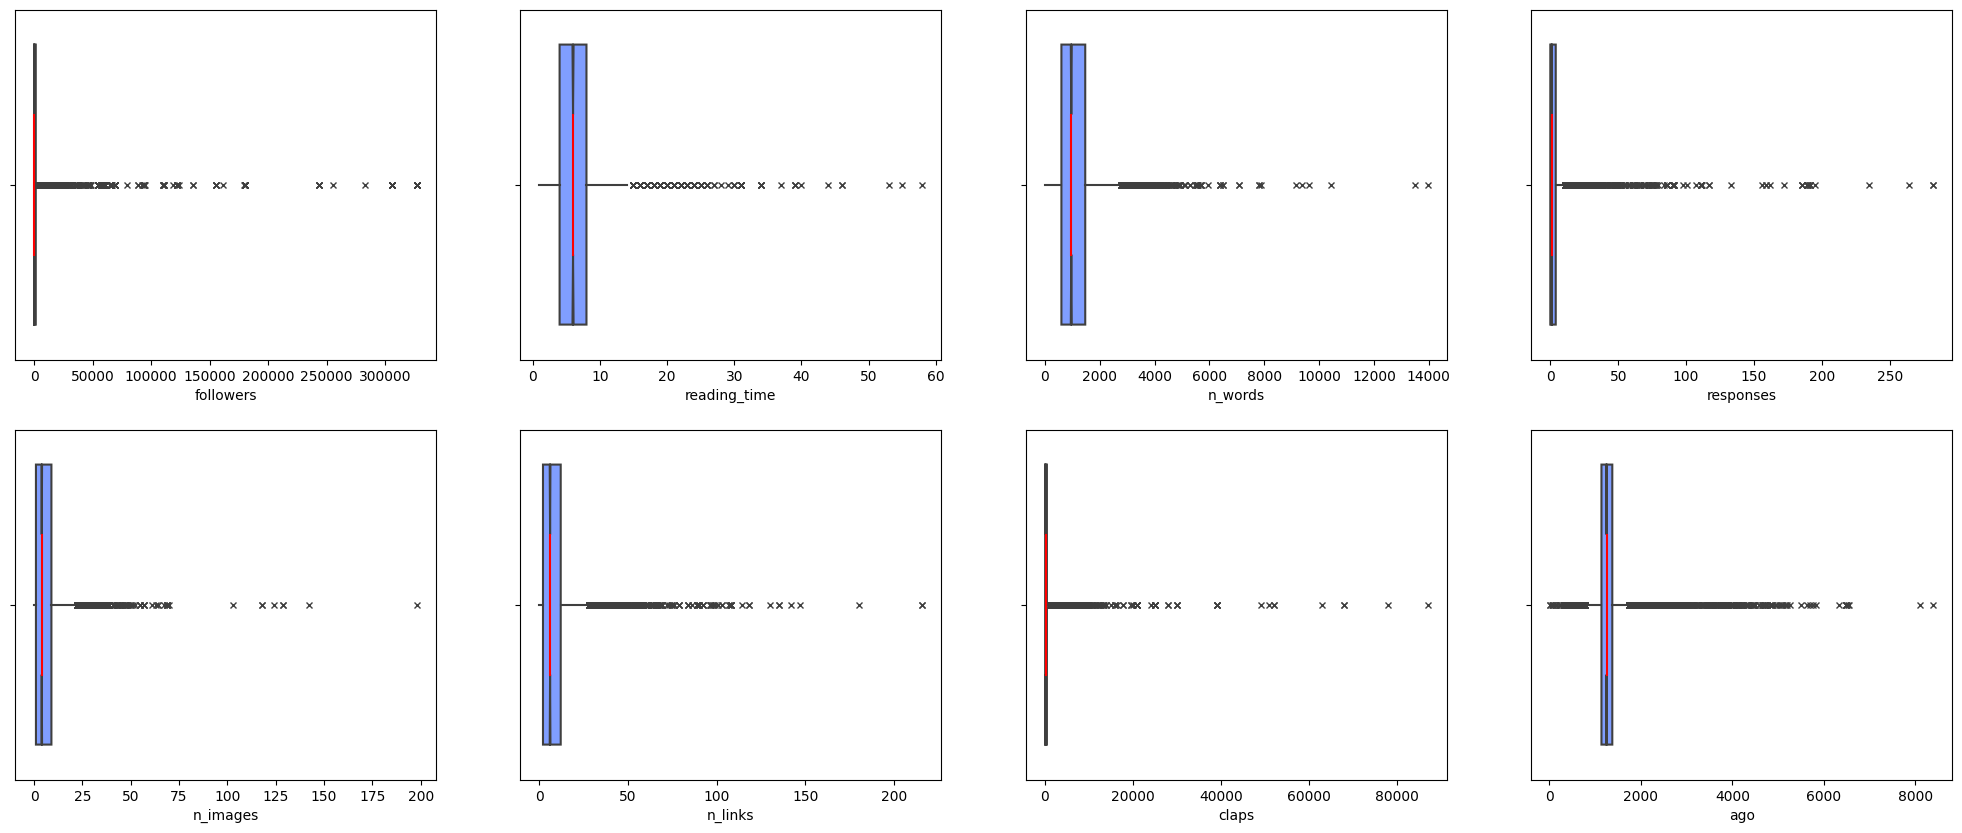

In [84]:
fig, ax = plt.subplots(2,4, figsize=(25, 10))

for i in range(len(num_cols_to_plot)):
    sns.boxplot(x=df[num_cols_to_plot[i]], notch=True, showcaps=False, flierprops={"marker": "x"}, boxprops={"facecolor": "#809eff"},
        medianprops={"color": "red"}, ax=ax[i//4, i%4])

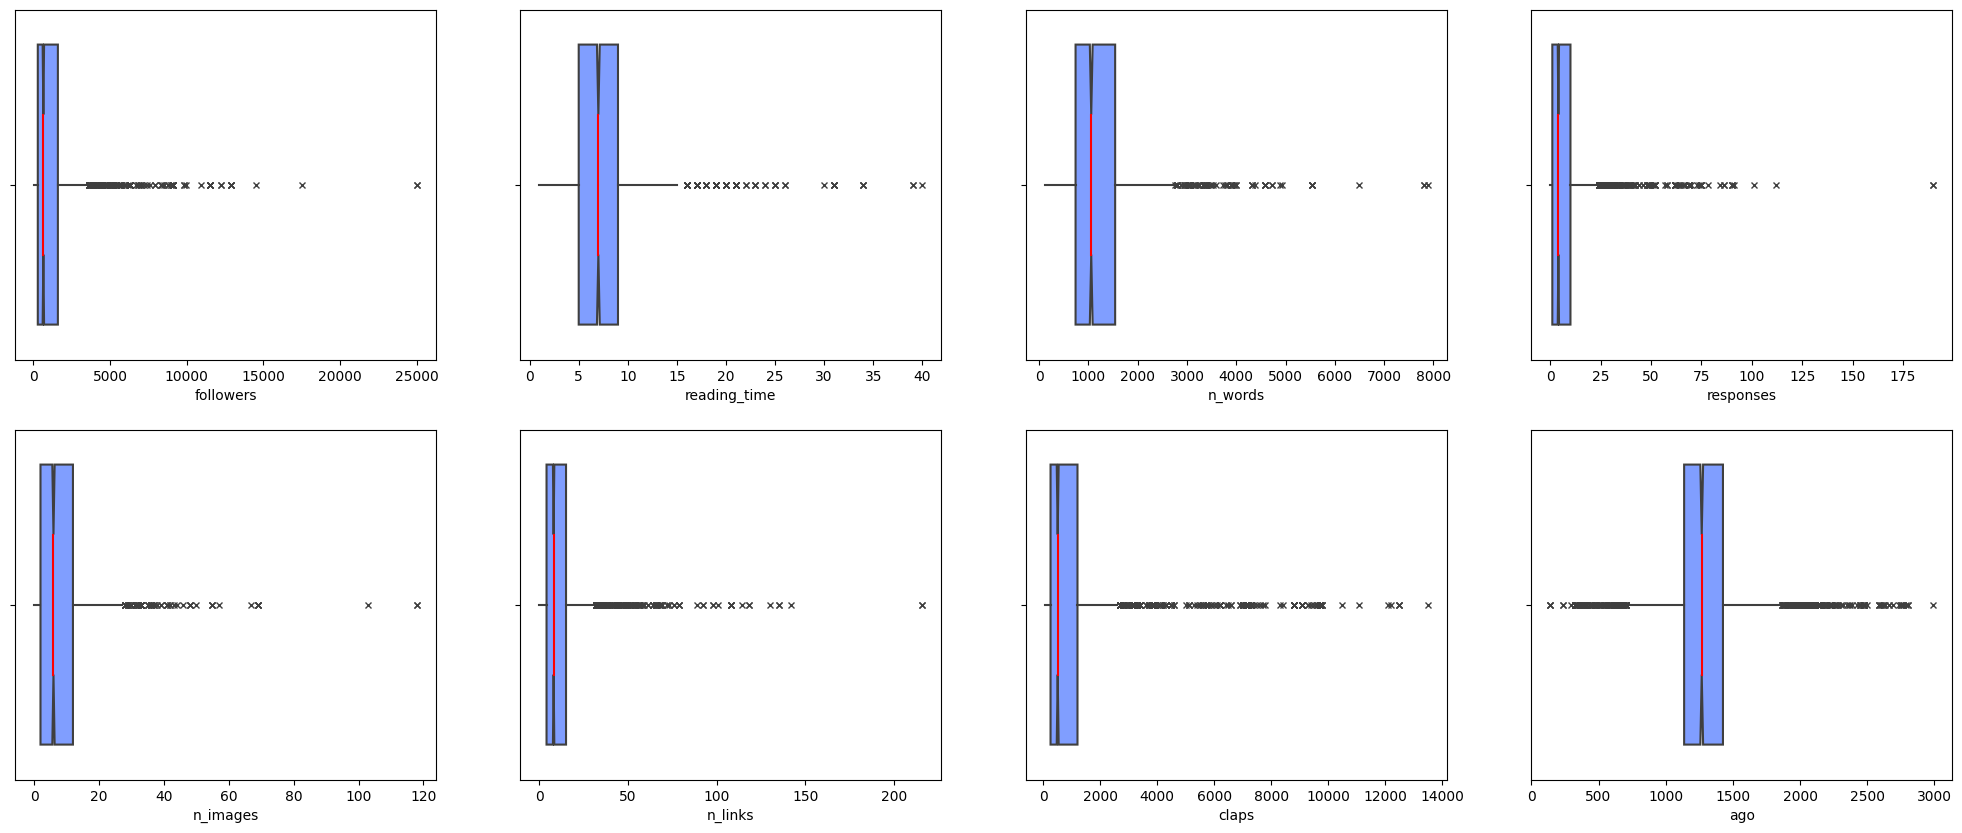

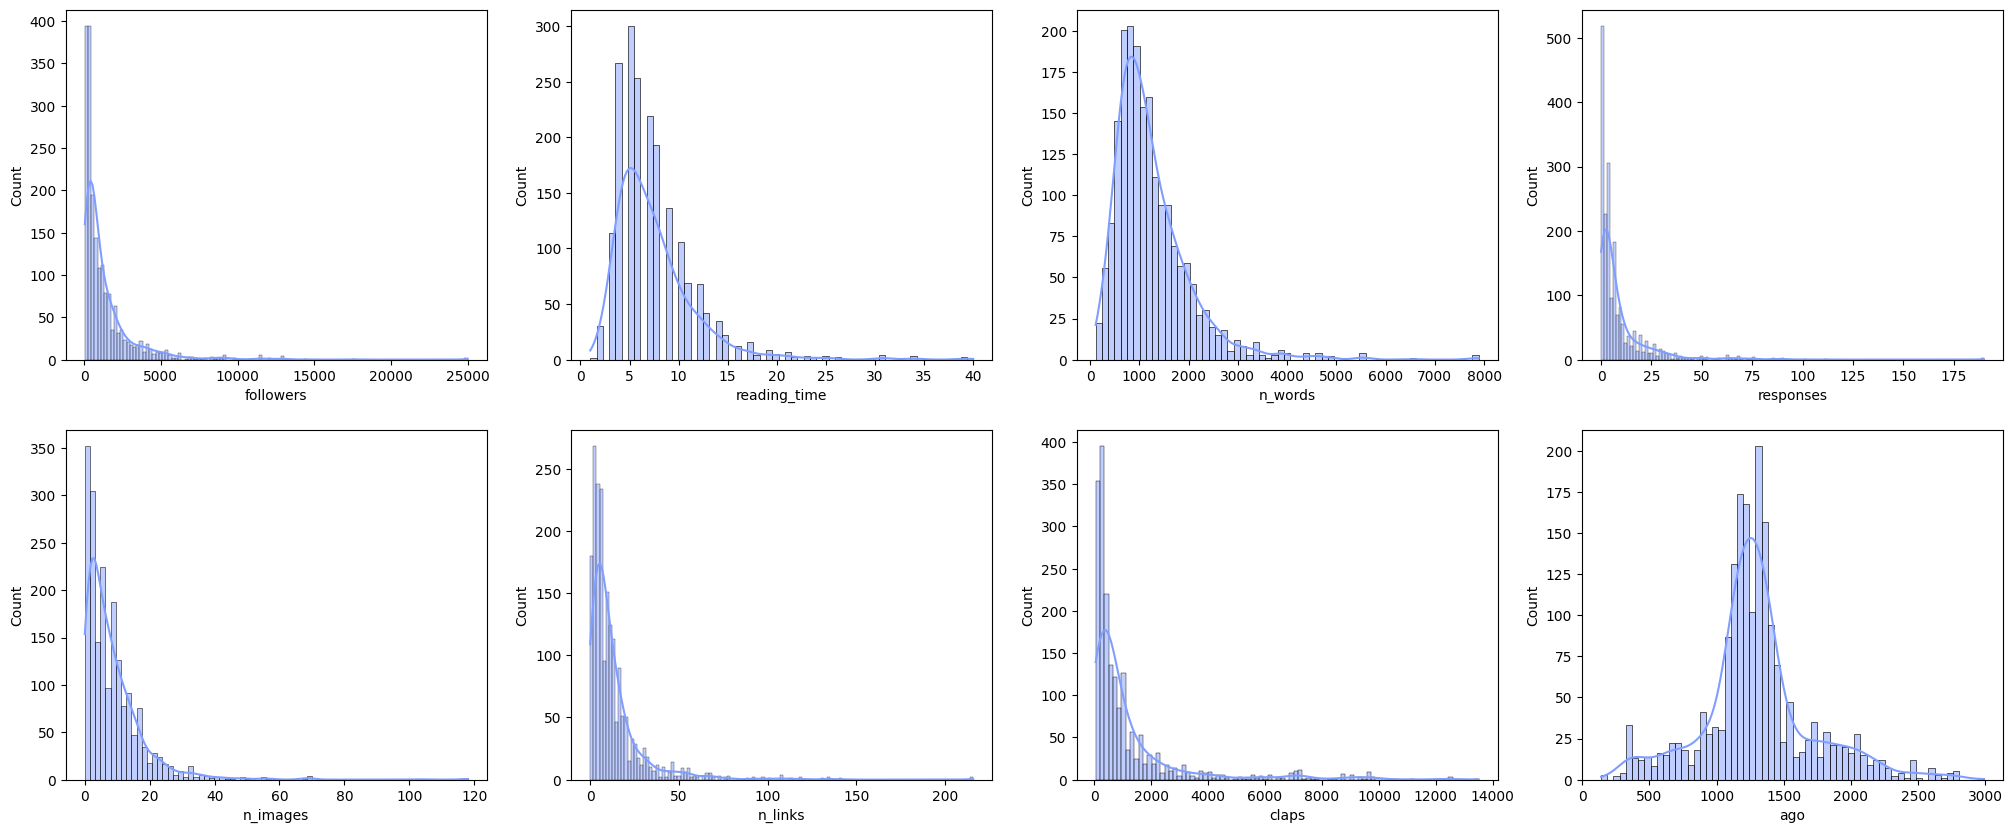

(1931, 8)


In [88]:
fig, ax = plt.subplots(2,4, figsize=(25, 10))

without_outliers = df[num_cols_to_plot].apply(hampel, axis=1).dropna()
for i in range(len(num_cols_to_plot)):
    sns.boxplot(x=without_outliers[num_cols_to_plot[i]], notch=True, showcaps=False, flierprops={"marker": "x"}, boxprops={"facecolor": "#809eff"},
        medianprops={"color": "red"}, ax=ax[i//4, i%4])
plt.show()

fig, ax = plt.subplots(2,4, figsize=(25, 10))

for i in range(len(num_cols_to_plot)):
    sns.histplot(x=without_outliers[num_cols_to_plot[i]], kde=True, ax=ax[i//4, i%4], color="#809eff")
plt.show()
print(without_outliers.shape)

Already better, but the data has become significantly smaller.

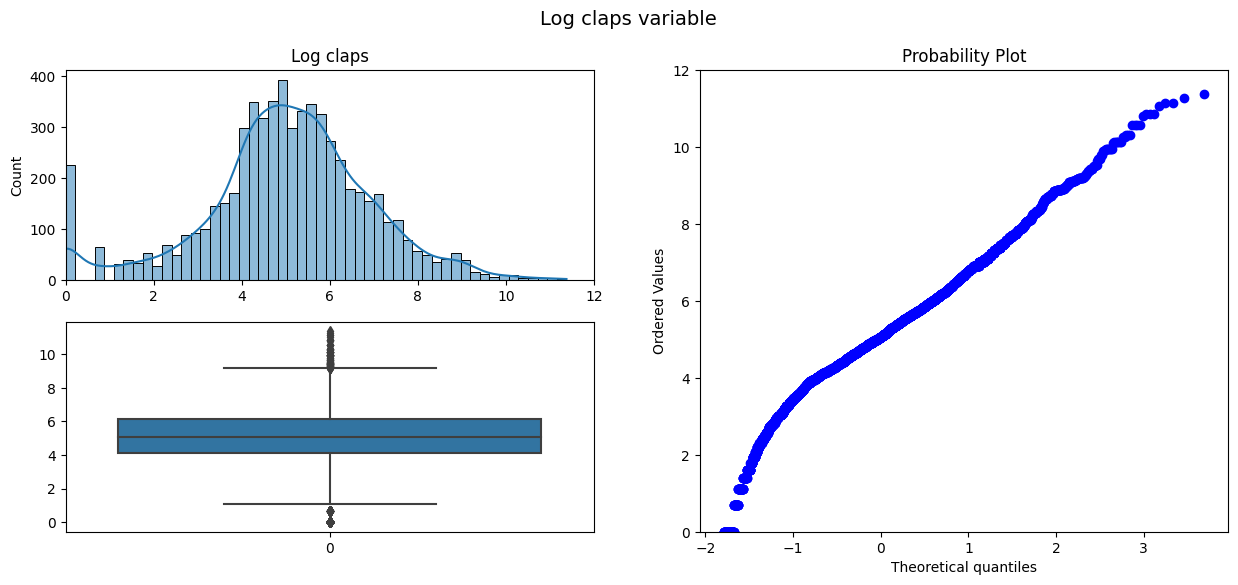

In [118]:
plt.figure(figsize=(15,6))
plt.suptitle("Log claps variable", fontsize=14)
gridspec.GridSpec(2,2)

plt.subplot2grid((2,2),(0,0))
plt.xlim(0, 12)
sns.histplot(np.log(df.claps.values + 1), kde=True, color=sns.color_palette()[0])
plt.title("Log claps")

plt.subplot2grid((2,2),(1,0))
plt.xlim(0, 12)
sns.boxplot(np.log(df.claps.values + 1))

plt.subplot2grid((2,2),(0,1), rowspan=2)
plt.ylim(0, 12)
probplot(np.log(df.claps.values), dist="norm", plot=plt, fit=True);

The empirical non-parametric distribution of logarithm of claps not so far from normal distribution. That is why we can use the parametric stats for this value. But we need to keep in mind that there are a lot of zeros and outliers.

In [21]:
df.claps.max()

87000

Lets watch on the categorical features

In [90]:
cols_pie_names = [
    "Publication type",
    "Year", "Month",
    "Day of week", 
    "Language", "Season"
] + keyword_columns
pie_cols = [
    'publication',
    'year', 'month',
    'dow', 'language',
    'season'
] + keyword_columns

In [91]:
len(pie_cols)

9

100%|██████████| 9/9 [00:00<00:00, 31.26it/s]


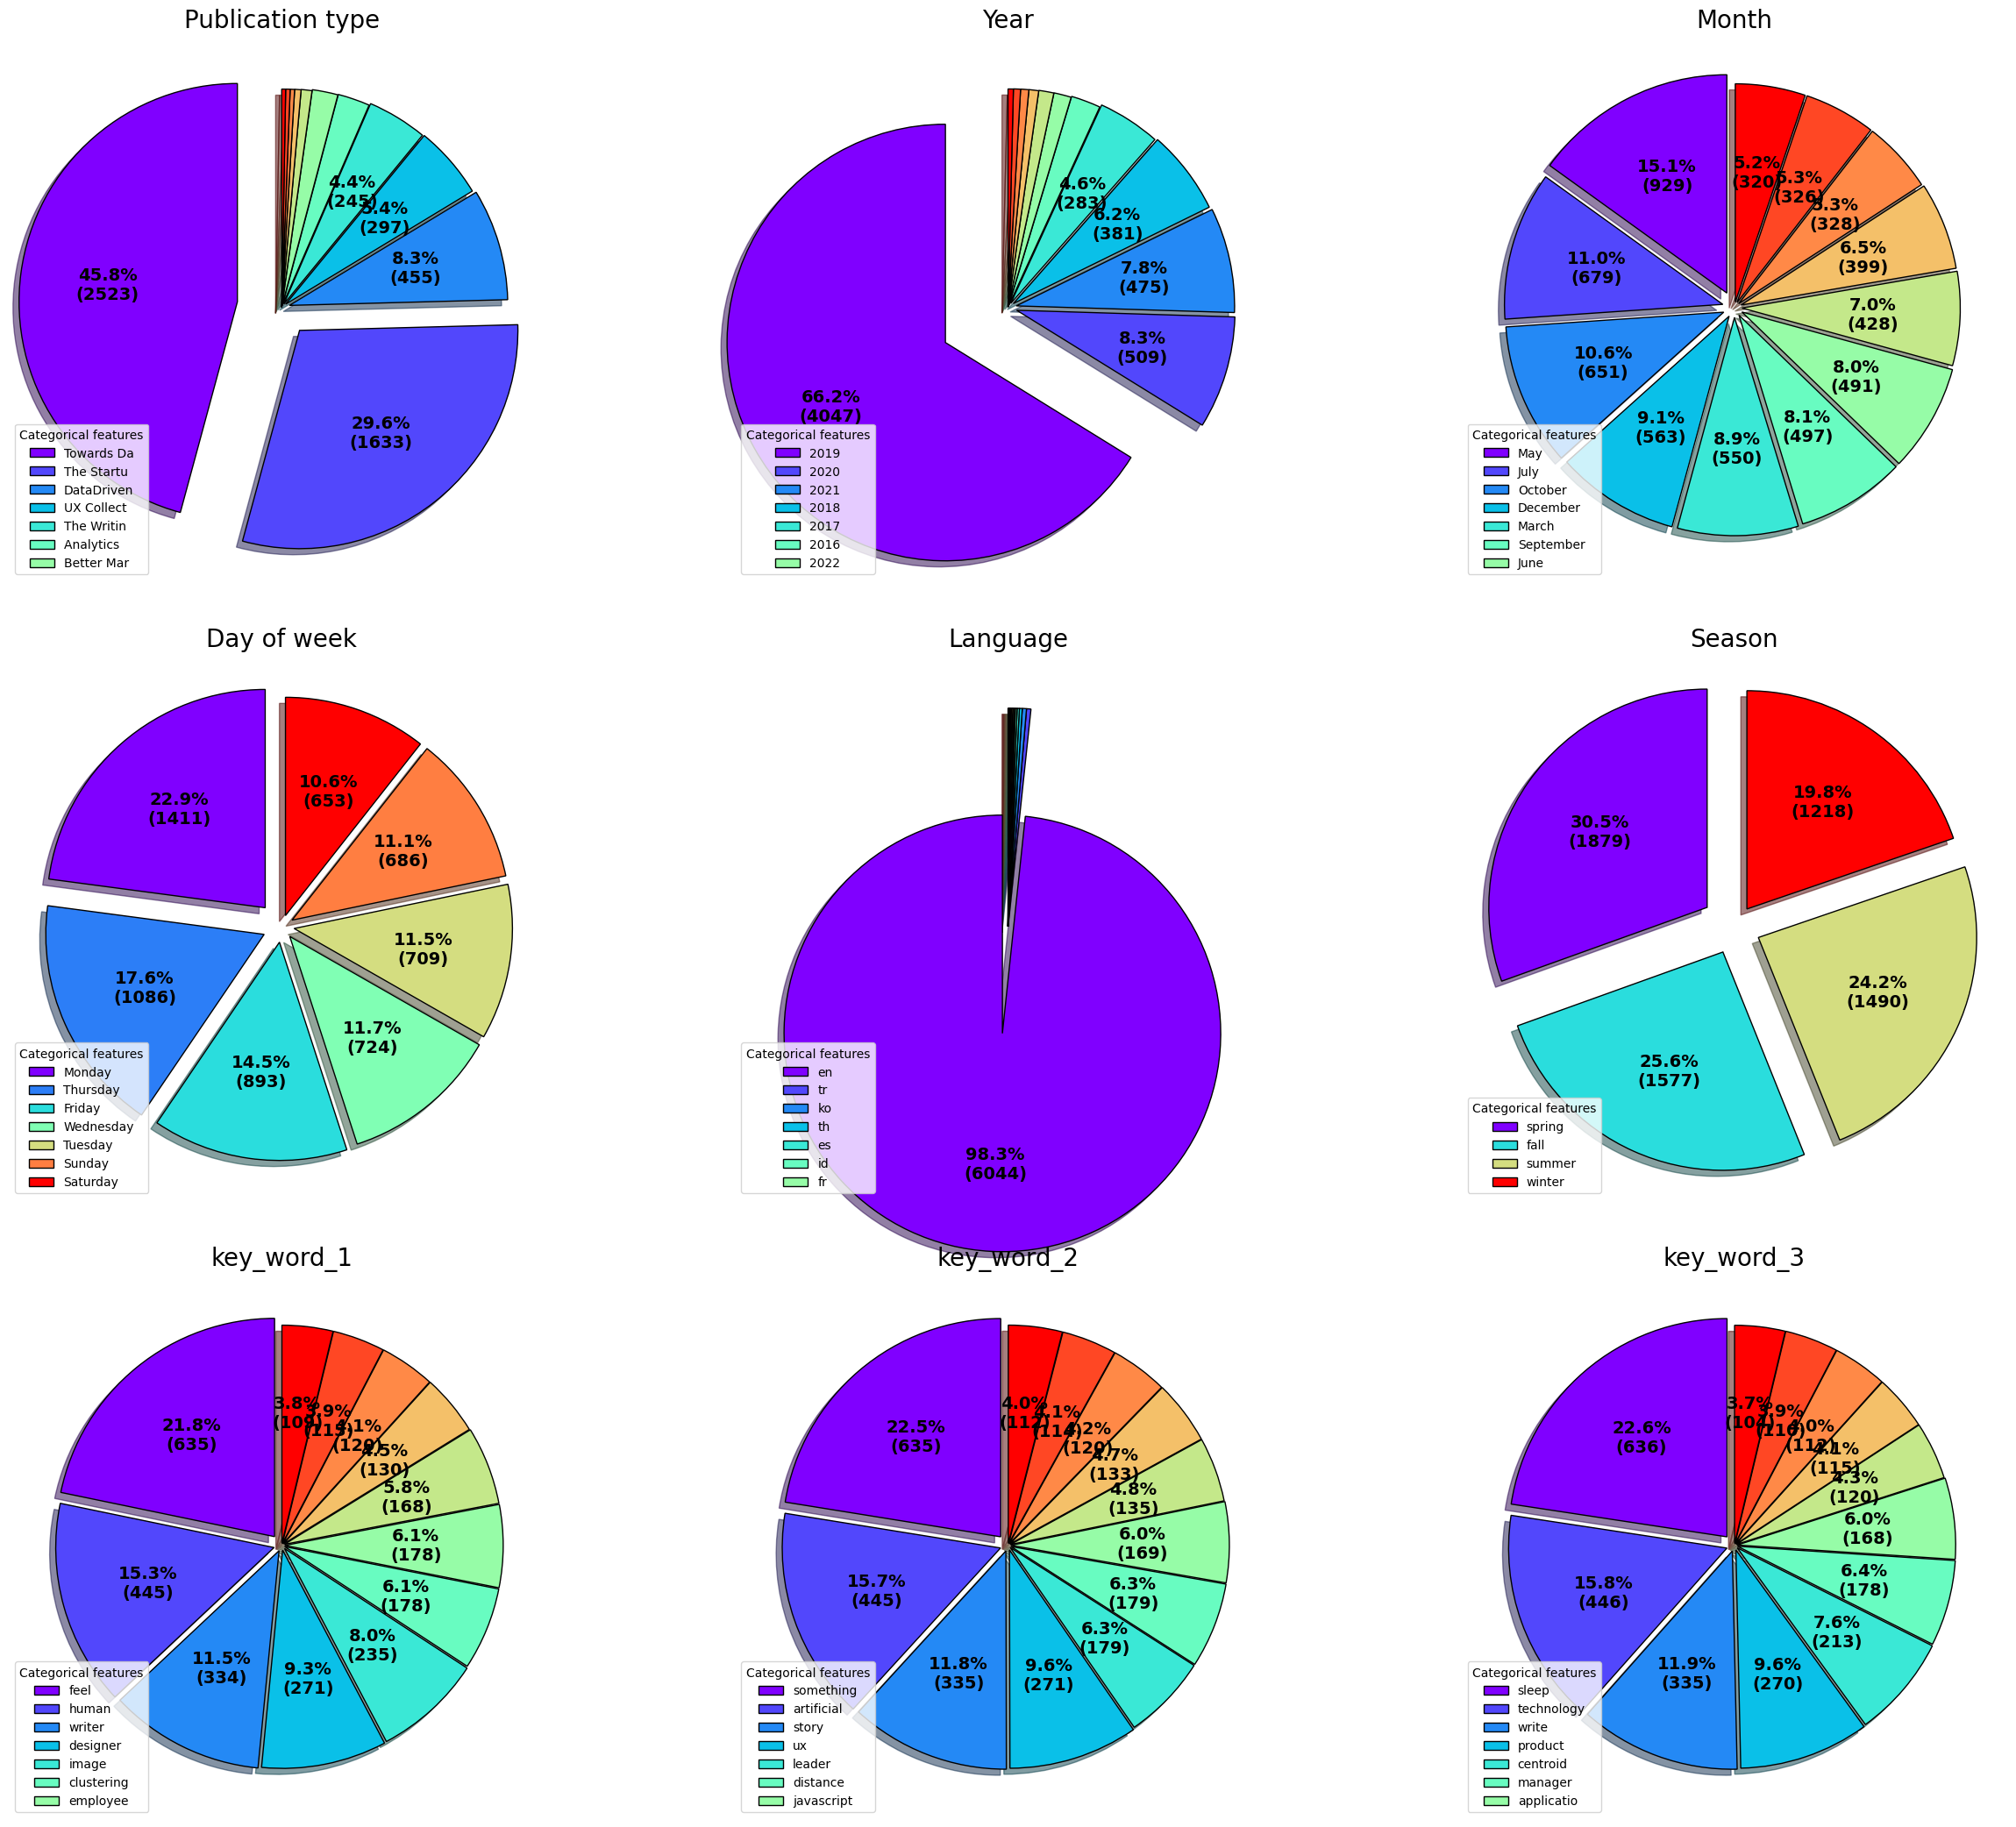

In [94]:

def func(pct, allvalues):
    absolute = int(pct / 100.*np.sum(allvalues))
    if pct > 2.5:
        return "{:.1f}%\n({:d})".format(pct, absolute)
    else:
        return ''
def get_cmap(n, name='hsv'):
    '''Returns a function that maps each index in 0, 1, ..., n-1 to a distinct 
    RGB color; the keyword argument name must be a standard mpl colormap name.'''
    return plt.cm.get_cmap(name, n)
# Creating plot
fig, ax = plt.subplots(3, 3, figsize =(25, 25))
for i, (col, title) in tqdm(enumerate(zip(pie_cols, cols_pie_names)), total=len(pie_cols)):
    vc = df[col].value_counts()
    data = vc.values.astype(int)[:12]
    labels = [st[:10] for st in df[col].value_counts().keys().astype(str)][:12]
    sum_ = df[col].value_counts().values.sum()
    explode = [i / sum_ / 2 for i in data]
    wp = { 'linewidth' : 1, 'edgecolor' : "black" }

    wedges, texts, autotexts = ax[i // 3][i % 3].pie(data, 
            autopct = lambda pct: func(pct, data), 
            explode=explode,
            wedgeprops=wp,
            colors=mcp.gen_color(cmap="rainbow",n=len(labels)),
            shadow=True,
            startangle=90)
    ax[i // 3][i % 3].legend(wedges, labels[:7],
          title ="Categorical features",
          loc ="lower left",
          bbox_to_anchor =(0, 0, 0.5, 1))
    ax[i // 3][i % 3].set_aspect('equal')
    ax[i // 3][i % 3].set_title(title, fontdict={'fontsize': 20})
    plt.setp(autotexts, size = 14, weight ="bold", color="black")
    plt.subplots_adjust(wspace=250, hspace=None)
plt.tight_layout()

In [304]:
import plotly.graph_objects as go

fig = go.Figure()

Let's check whether dependencies between claps, length of articles and followers exists or not.

In [453]:

mask = (df.num_words > 0) & (df.claps > 0)
followers = df.followers[mask].copy()
followers[followers > 2000] = 2000

fig = px.scatter(x=np.log(df.num_words[mask]), y=np.log(df.claps[mask]), color=followers, opacity=0.7)

fig.update_layout(
    title="Followers (as color), number of words and log claps",
    xaxis_title="Log number of words",
    yaxis_title="Log claps",
    legend_title="Legend Title",
    font=dict(
        family="Courier New, monospace",
        size=18,
        color="#1b3b72"
    )
)

As we see, data splits into two clearly separated groups. Moreover, this plot shows that authors with more followers get more claps. However, there is no visible dependency of number of followers and length of articles.

Let's take a look, how publications are located on this plot for 5 most popular publications.

In [511]:
top_5_publications = df.publication.value_counts().index[:5]

df_view = df[df.publication.isin(top_5_publications)]
mask = (df_view.n_words > 0) & (df_view.claps > 0)

px.scatter(x=np.log(df_view.n_words[mask]), y=np.log(df_view.claps[mask]), color=df_view.publication[mask], opacity=0.7)

The Startup publishings split into two separate groups while others are in the same cluster.

 Let's look at 5 most popular topics for The Startup.

In [512]:
top_5_topics = df[df.publication == "The Startup"].topic_name.value_counts()[:5].index

df_view = df[(df.publication == "The Startup") & (df.topic_name.isin(top_5_topics))]
mask = (df_view.n_words > 0) & (df_view.claps > 0)

px.scatter(x=np.log(df_view.n_words[mask]), y=np.log(df_view.claps[mask]), color=df_view.topic_name[mask], opacity=0.7)

There is no visible dependency of cluster and topic of the article.

Let's look at the distribution of claps by 10 most popular topics.


In [513]:
top_10_topics = df.topic_name.value_counts()[:10].index

data_view = df[df.topic_name.isin(top_10_topics)]

fig = px.histogram(x=data_view.topic_name, y=data_view.claps, histfunc="avg")

fig.update_layout(
    title="The most popular topics",
    xaxis_title="Topic name",
    yaxis_title="Claps",
    legend_title="Legend Title",
    font=dict(
        family="Futura Round Demi, monospace",
        size=18,
        color="#1b3b72"
    )
)

As we see "cnn" topic receives the most number of claps between others.

Let's check how number of followers relates with of number of claps.

In [514]:
mask = (df.claps > 0) & (df.followers > 0)
fig = px.scatter(x=np.log(df.followers[mask]), y=np.log(df.claps[mask]), trendline="ols",
           trendline_color_override="black", opacity=0.5)
fig.update_layout(
    title="Dependence between log followers and log claps",
    xaxis_title="Log followers",
    yaxis_title="Log claps",
    legend_title="Legend Title",
    font=dict(
        family="Futura Round Demi, monospace",
        size=18,
        color="#1b3b72"
    )
)

As we see, the logarithm of claps linearly depends from logarithm of number of followers.

In [100]:
dates = df.date.sort_values()

px.scatter(x=range(len(dates)), y=dates)

The most articles in the dataset are from 2019th.

Let's check if difference of claps and day of weeks exists.

In [515]:
px.histogram(data_frame=df, x='dow', y='claps', histfunc="avg")

I guess the mood on the weekend is better than the work week, so you can put a bunch of claps.

In [328]:
fig = go.Figure()
fig.add_trace(go.Histogram2dContour(
        x = np.log(df.n_words),
        y = np.log(df.claps),
        colorscale = 'Blues',
        reversescale = True,
        xaxis = 'x',
        yaxis = 'y'
    ))
fig.add_trace(go.Scatter(
        x = np.log(df.n_words),
        y = np.log(df.claps),
        xaxis = 'x',
        yaxis = 'y',
        mode = 'markers',
        marker = dict(
            color = 'rgba(0,0,0,1)'
        )

    ))
fig.add_trace(go.Histogram(
        y = np.log(df.claps),
        xaxis = 'x2',
        marker = dict(
            color = 'rgba(0,0,0,1)'
        )
    ))
fig.add_trace(go.Histogram(
        x = np.log(df.n_words),
        yaxis = 'y2',
        marker = dict(
            color = 'rgba(0,0,0,1)'
        )
    ))

fig.update_layout(
    autosize = False,
    xaxis = dict(
        zeroline = False,
        domain = [0,0.85],
        showgrid = False
    ),
    yaxis = dict(
        zeroline = False,
        domain = [0,0.85],
        showgrid = False
    ),
    xaxis2 = dict(
        zeroline = False,
        domain = [0.85,1],
        showgrid = False
    ),
    yaxis2 = dict(
        zeroline = False,
        domain = [0.85,1],
        showgrid = False
    ),
    height = 600,
    width = 600,
    bargap = 0,
    hovermode = 'closest',
    showlegend = False
)

fig.show()

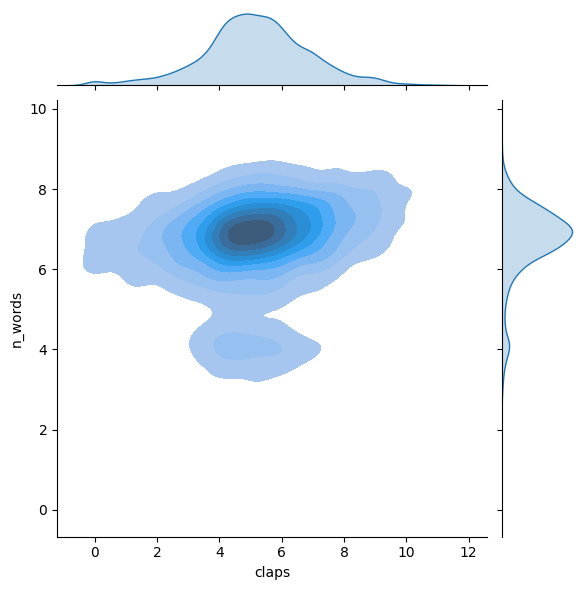

In [352]:

ax = sns.jointplot(x=np.log(df.claps), y=np.log(df.n_words), kind="kde", joint_kws={"shade": True}, marginal_kws={"shade": True})

Almost no linear dependence.

In [516]:
top_5_popular_publications = df["publication"].value_counts()[:5].index
claps = df.loc[df.publication.isin(top_5_popular_publications)].groupby('publication')['claps'].mean().sort_values(ascending=False).reset_index()
px.bar(claps, x="publication", y="claps")

In [401]:
responses = df.loc[df.publication.isin(top_5_popular_publications)].groupby('publication')['responses'].median().sort_values(ascending=False).reset_index()
px.bar(responses, x="publication", y="responses")

The Toward Data Science is leading. I suppose it is merely because of its popularity.

In [517]:
date_gr = df.loc[df.publication.isin(top_5_popular_publications)].groupby('month')['publication'].count().sort_values(ascending=False).reset_index()

plt.figure(figsize = (10,8))
px.bar(date_gr, x= 'month', y='publication', color = 'publication',hover_data=['publication'],
       title="Month wise Publication" )

<Figure size 1000x800 with 0 Axes>

The most of publications submitted in the May. It can be interpreted in the following way: graduation required at the end of the academic year. The least publications submitted in January in case of New Year I suppose.

Let's check the distribution through authors.

In [351]:
top_10_popular_authors = df.author.value_counts()[:10].index
claps = df.loc[df.author.isin(top_10_popular_authors)].groupby('author').claps.median().sort_values(ascending=False).reset_index()
px.bar(claps, x="author", y="claps")

The most popular author is Adam Geitgey. Let's take a look on the picture without him

In [354]:
top_10_popular_authors = df.author.value_counts()[:10].index
claps = df.loc[df.author.isin(set(top_10_popular_authors) - set(["Adam Geitgey"]))].groupby('author').claps.median().sort_values(ascending=False).reset_index()
px.bar(claps, x="author", y="claps")

Much better, now we can see competitors. Let's check equality homoscedasticity and equal of expectations between claps for this 3 authors further.

In [358]:
top_3_popular_authors = claps.author.values[:3]

In [361]:
df_view = df.loc[df.author.isin(top_3_popular_authors)]

Let's start with homoscedasticity:

In [363]:
pg.homoscedasticity(df_view, dv="claps", group="author")

W      pval  equal_var
levene  2.231574  0.120892       True

These groups have similar variances. Let's check normal distribution of claps for them by Jarque-Bera criteria

In [364]:
pg.normality(df_view, dv="claps", group="author", method="jarque_bera")

W      pval  normal
Parul Pandey  3.954393  0.138457    True
Raimi Karim   1.248158  0.535755    True
Susan Li      4.277733  0.117788    True

Cool. ``p-value`` is significant. Now we can make a one-way ANOVA test

In [365]:
pg.anova(df_view, dv="claps", between="author")

Source  ddof1  ddof2         F     p-unc       np2
0  author      2     39  0.609543  0.548696  0.030311

We have the big ``p-value``, that is why we cant deny the hypothesis about equivalence of expectations.

Let me make the same operations for the articles topics

In [366]:
top_10_topics = df.topic_name.value_counts()[:10].index

In [518]:
df_view = df.loc[df.topic_name.isin(top_10_topics)]
df_view["log_claps"] = np.log(df_view["claps"]+1)

In [519]:
pg.homoscedasticity(df_view, dv="log_claps", group="topic_name")

W          pval  equal_var
levene  14.745301  1.455902e-23      False

We can obtain that homoscedasticity doesn't save

In [520]:
pg.normality(df_view, dv="log_claps", group="topic_name", method="jarque_bera")

W          pval  normal
descent         1.699129  4.276010e-01    True
app            59.897678  9.847678e-14   False
design         77.607236  0.000000e+00   False
life          144.924307  0.000000e+00   False
book           64.126667  1.187939e-14   False
team           14.040128  8.937682e-04   False
intelligence   17.075295  1.959507e-04   False
stock           3.219914  1.998962e-01    True
cluster        13.877574  9.694447e-04   False
cnn             4.785431  9.138118e-02    True

We have bad ``p-values`` for almost all our groups. Let me try to plot qq-plot

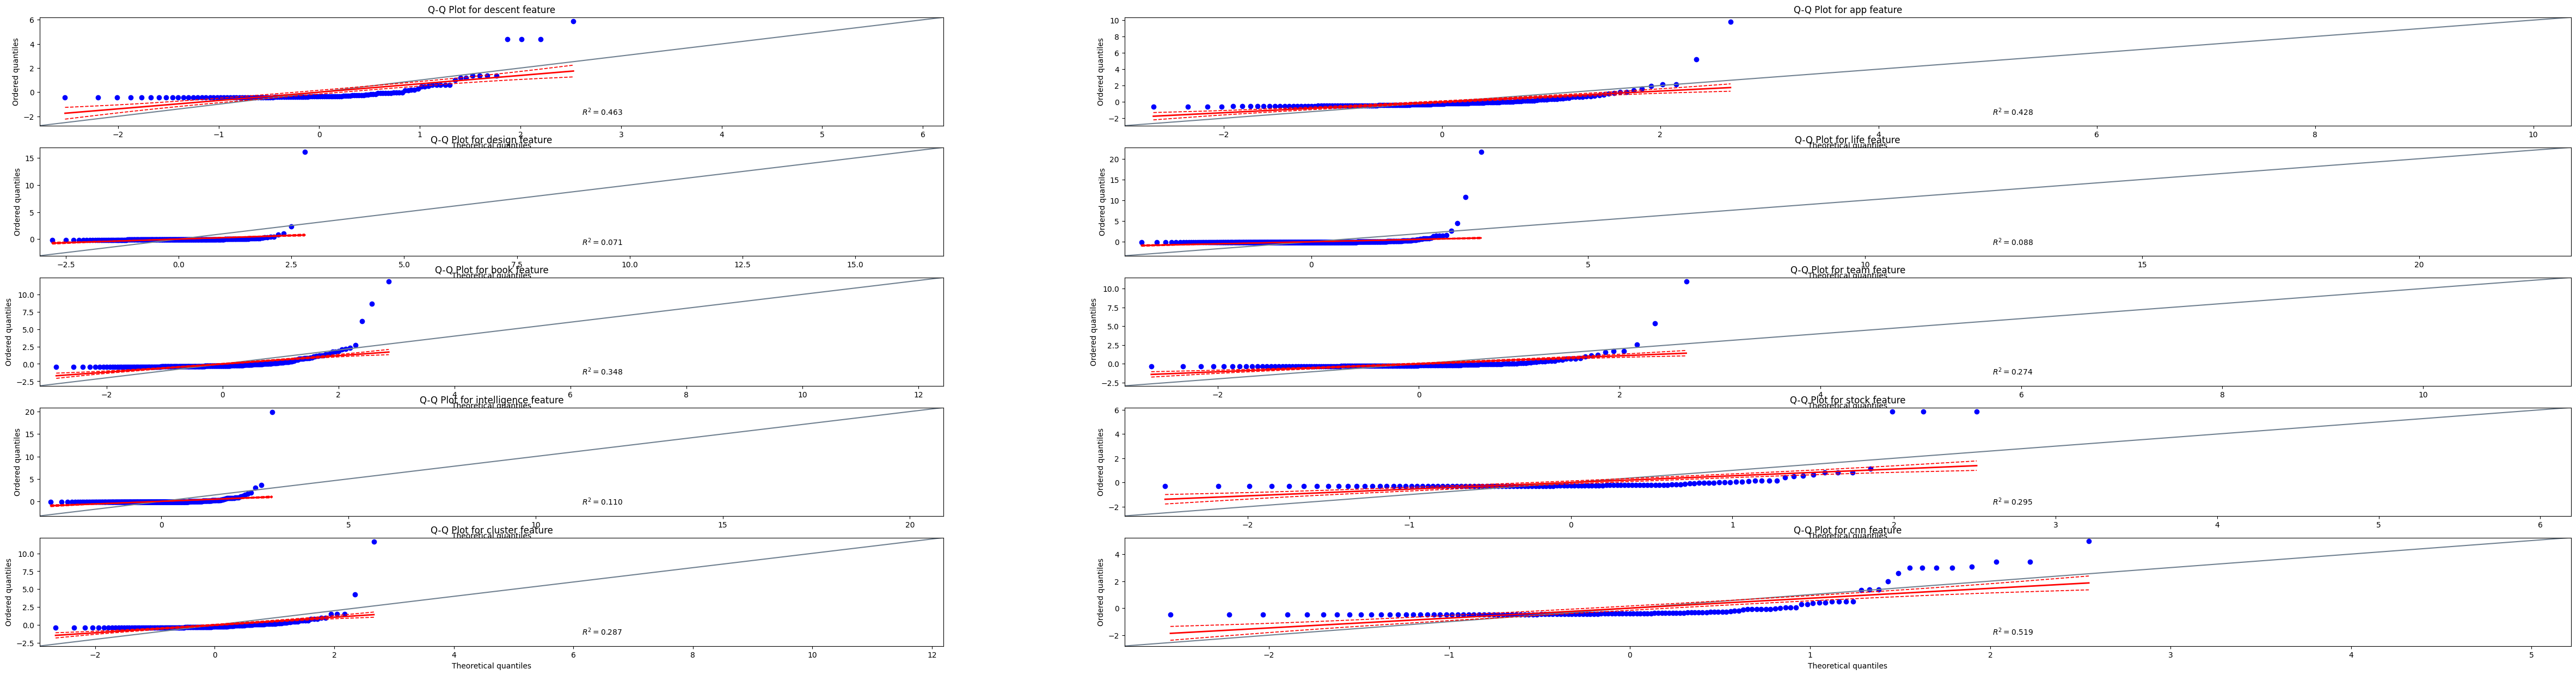

In [521]:

plt.figure(figsize=(60,15))
categories = df_view["topic_name"].unique()
gs = gridspec.GridSpec(5, 5)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2])
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, :2])
ax4 = plt.subplot(gs[1, 2:])
ax5 = plt.subplot(gs[2, :2])
ax6 = plt.subplot(gs[2, 2:])
ax7 = plt.subplot(gs[3, :2])
ax8 = plt.subplot(gs[3, 2:])
ax9 = plt.subplot(gs[4, :2])
ax10 = plt.subplot(gs[4, 2:])

axes = [ax1, ax2, ax3, ax4, ax5, 
        ax6, ax7, ax8, ax9, ax10]
assert len(axes) == len(categories)

for ax, cat in zip(axes, categories):
    mask = df_view["topic_name"] == cat
    sample = df_view.loc[mask, "claps"]
    pg.qqplot(sample, ax=ax)
    ax.set_title(f"Q-Q Plot for {cat} feature")
    ax.grid(False)


Yes, it is tough to tell something about normal distribution. Then we can use just Games-Howell test because of its robustness to the non-normal distributions:

In [386]:
pg.pairwise_gameshowell(df_view, dv="log_claps", between="topic_name")

A             B   mean(A)   mean(B)      diff        se  \
0            app          book  4.924671  5.040037 -0.115366  0.141934   
1            app       cluster  4.924671  5.070759 -0.146089  0.190040   
2            app           cnn  4.924671  4.998040 -0.073369  0.239151   
3            app       descent  4.924671  4.732686  0.191985  0.216107   
4            app        design  4.924671  4.884375  0.040296  0.142471   
5            app  intelligence  4.924671  4.230781  0.693889  0.152924   
6            app          life  4.924671  4.877836  0.046834  0.130073   
7            app         stock  4.924671  4.629508  0.295163  0.225930   
8            app          team  4.924671  4.581763  0.342908  0.157510   
9           book       cluster  5.040037  5.070759 -0.030723  0.172766   
10          book           cnn  5.040037  4.998040  0.041996  0.225668   
11          book       descent  5.040037  4.732686  0.307351  0.201085   
12          book        design  5.040037  4.884375  0.155661  0.118451   
13          book  intelligence  5.040037  4.230781  0.809255  0.130837   
14          book          life  5.040037  4.877836  0.162200  0.103207   
15          book         stock  5.040037  4.629508  0.410529  0.211606   
16          book          team  5.040037  4.581763  0.458274  0.136170   
17       cluster           cnn  5.070759  4.998040  0.072719  0.258643   
18       cluster       descent  5.070759  4.732686  0.338074  0.237498   
19       cluster        design  5.070759  4.884375  0.186384  0.173207   
20       cluster  intelligence  5.070759  4.230781  0.839978  0.181903   
21       cluster          life  5.070759  4.877836  0.192923  0.163162   
22       cluster         stock  5.070759  4.629508  0.441252  0.246470   
23       cluster          team  5.070759  4.581763  0.488997  0.185775   
24           cnn       descent  4.998040  4.732686  0.265355  0.278358   
25           cnn        design  4.998040  4.884375  0.113665  0.226006   
26           cnn  intelligence  4.998040  4.230781  0.767259  0.232737   
27           cnn          life  4.998040  4.877836  0.120204  0.218403   
28           cnn         stock  4.998040  4.629508  0.368532  0.286051   
29           cnn          team  4.998040  4.581763  0.416277  0.235776   
30       descent        design  4.732686  4.884375 -0.151690  0.201464   
31       descent  intelligence  4.732686  4.230781  0.501904  0.208987   
32       descent          life  4.732686  4.877836 -0.145151  0.192896   
33       descent         stock  4.732686  4.629508  0.103178  0.267085   
34       descent          team  4.732686  4.581763  0.150923  0.212366   
35        design  intelligence  4.884375  4.230781  0.653594  0.131419   
36        design          life  4.884375  4.877836  0.006539  0.103944   
37        design         stock  4.884375  4.629508  0.254867  0.211967   
38        design          team  4.884375  4.581763  0.302612  0.136729   
39  intelligence          life  4.230781  4.877836 -0.647055  0.117865   
40  intelligence         stock  4.230781  4.629508 -0.398726  0.219129   
41  intelligence          team  4.230781  4.581763 -0.350982  0.147590   
42          life         stock  4.877836  4.629508  0.248329  0.203841   
43          life          team  4.877836  4.581763  0.296073  0.123758   
44         stock          team  4.629508  4.581763  0.047745  0.222354   

           T          df          pval    hedges  
0  -0.812815  343.259465  9.983642e-01 -0.076576  
1  -0.768725  327.176073  9.989452e-01 -0.082271  
2  -0.306791  199.526273  9.999996e-01 -0.035936  
3   0.888380  208.387218  9.966859e-01  0.105773  
4   0.282835  336.498765  9.999998e-01  0.027675  
5   4.537492  430.290662  3.139464e-04  0.409365  
6   0.360063  270.093086  9.999982e-01  0.031131  
7   1.306435  191.623291  9.511627e-01  0.157506  
8   2.177052  342.998238  4.746583e-01  0.232994  
9  -0.177829  288.074567  1.000000e+00 -0.016440  
10  0.186098  167.317693  1.000000e+00  0.019361 

As a result, we can conclude, that ``app`` and ``intelligence`` groups more statistically significant, than others. We deny hypothesis of equality of expectations.

Let's try with the articles with low ``popularity``

In [522]:
tail_10_topics = df.topic_name.value_counts()[-10:].index 

In [523]:
df_view = df.loc[df.topic_name.isin(tail_10_topics)]
df_view["log_claps"] = np.log(df_view["claps"]+1)

In [524]:
pg.homoscedasticity(df_view, dv="log_claps", group="topic_name")

W      pval  equal_var
levene  1.636134  0.115117       True

In [525]:
pg.normality(df_view, dv="log_claps", group="topic_name", method="jarque_bera")

W      pval  normal
lane        0.103070  0.949770    True
hypothesis  1.228561  0.541030    True
validation  0.245285  0.884580    True
อม          0.958666  0.619196    True
colour      9.444115  0.008897   False
johnson     1.625013  0.443744    True
pi          0.132494  0.935900    True
memory      0.834421  0.658882    True
cat         1.341406  0.511349    True
google      1.233647  0.539656    True

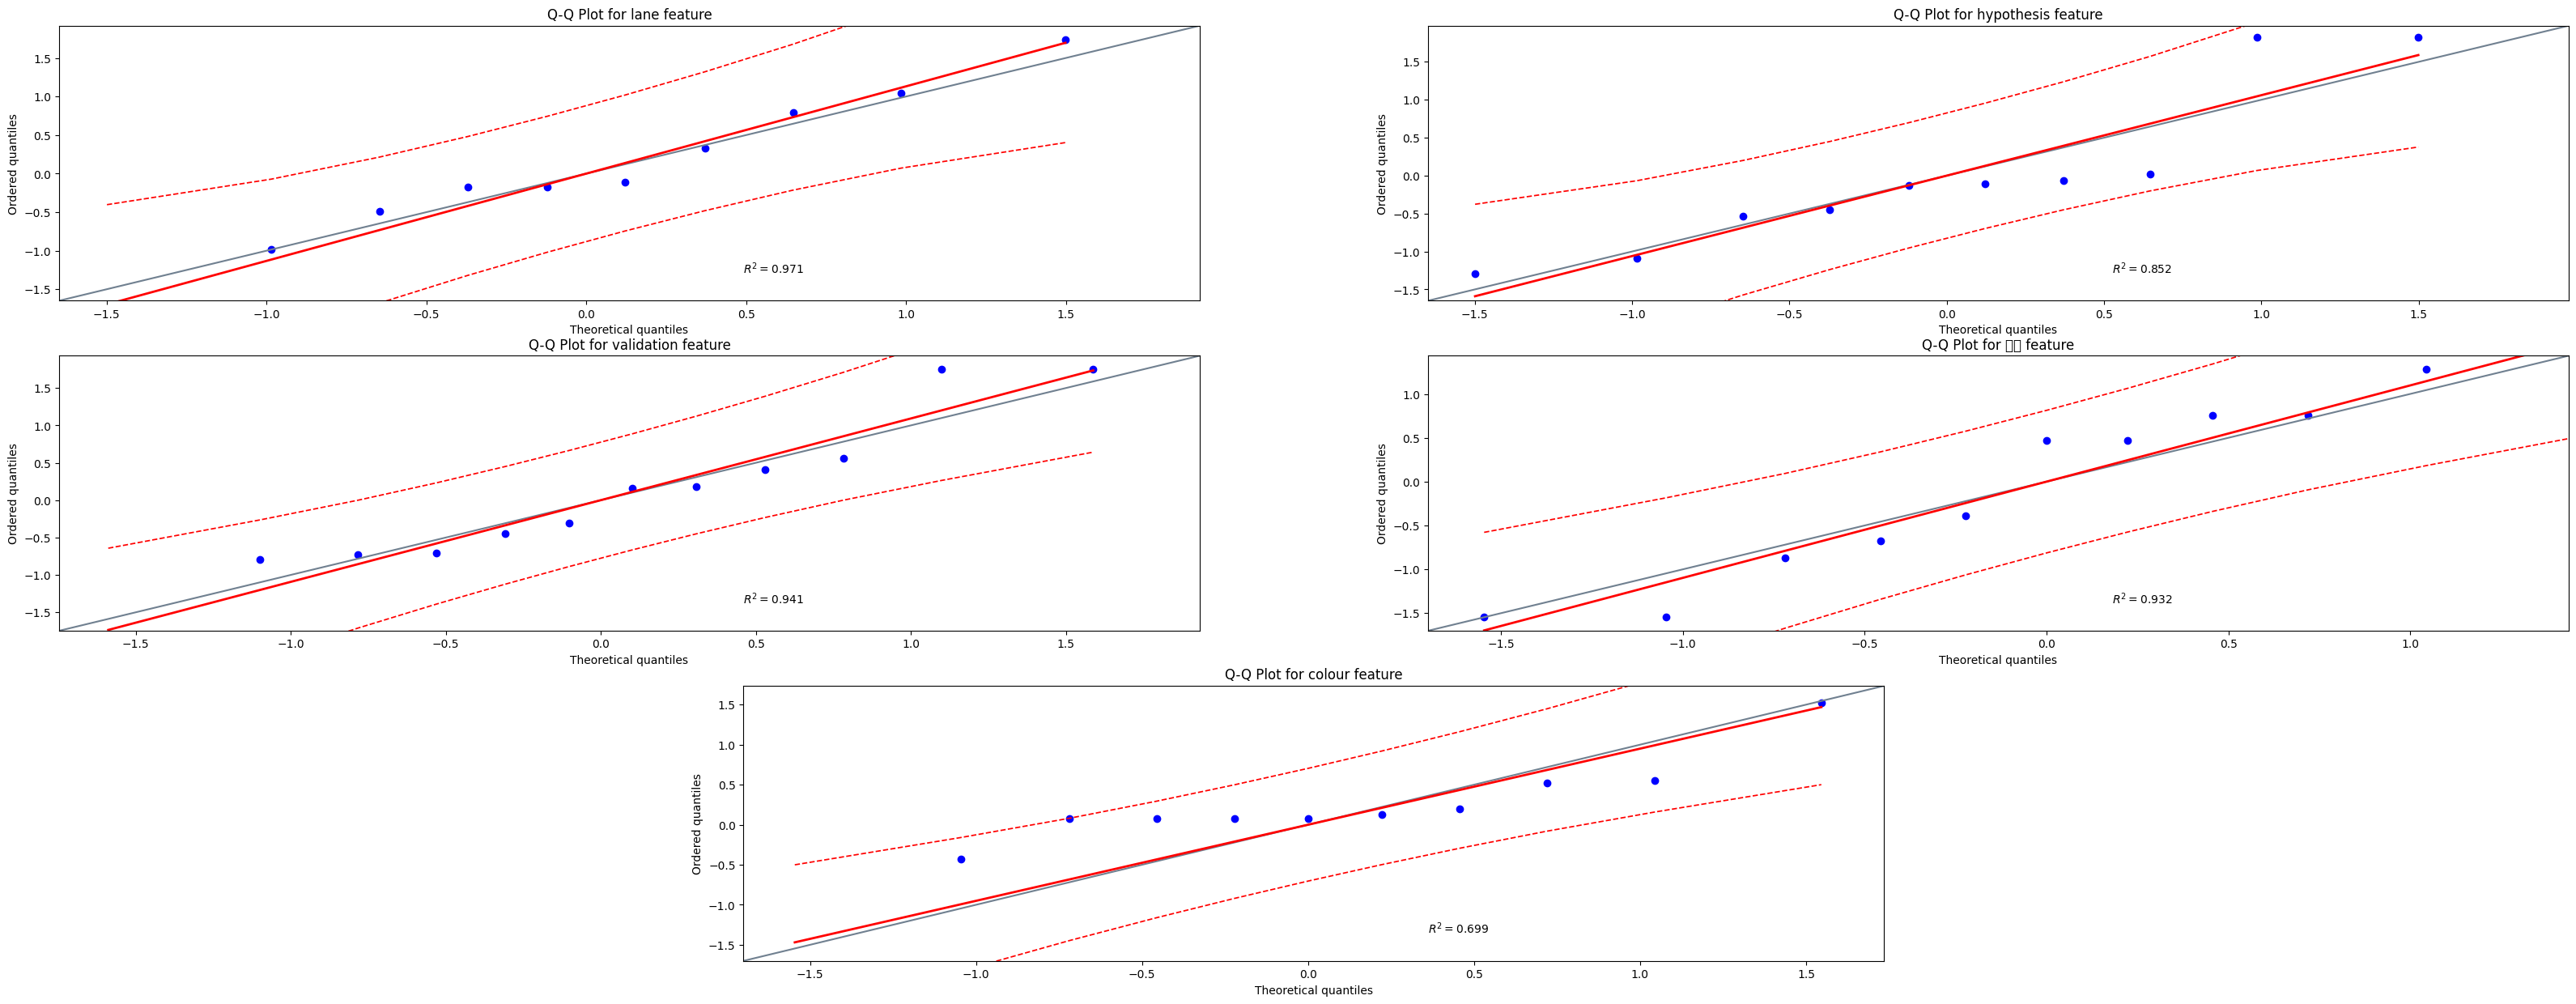

In [526]:
plt.figure(figsize=(40,15))
categories = df_view["topic_name"].unique()
gs = gridspec.GridSpec(3, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2])
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, :2])
ax4 = plt.subplot(gs[1, 2:])
ax5 = plt.subplot(gs[2, 1:3])

axes = [ax1, ax2, ax3, ax4, ax5]
for ax, cat in zip(axes, categories):
    mask = df_view["topic_name"] == cat
    sample = df_view.loc[mask, "log_claps"]
    pg.qqplot(sample, ax=ax)
    ax.set_title(f"Q-Q Plot for {cat} feature")
    ax.grid(False)


It looks good. Even the worst sample look much more convenient than all objects in the previous iteration.

In [485]:
pg.pairwise_gameshowell(df_view, dv="log_claps", between="topic_name")

A           B   mean(A)   mean(B)      diff        se         T  \
0          cat      colour  4.965838  4.783882  0.181956  0.747788  0.243326   
1          cat      google  4.965838  4.781916  0.183923  0.767367  0.239680   
2          cat  hypothesis  4.965838  4.765658  0.200181  0.800374  0.250109   
3          cat     johnson  4.965838  4.349690  0.616148  0.738284  0.834568   
4          cat        lane  4.965838  5.121317 -0.155478  0.590737 -0.263194   
5          cat      memory  4.965838  6.465210 -1.499372  0.959555 -1.562570   
6          cat          pi  4.965838  5.568670 -0.602832  0.600554 -1.003792   
7          cat  validation  4.965838  4.499247  0.466591  0.902160  0.517194   
8          cat          อม  4.965838  3.202961  1.762878  0.836874  2.106503   
9       colour      google  4.783882  4.781916  0.001967  0.782920  0.002512   
10      colour  hypothesis  4.783882  4.765658  0.018225  0.815297  0.022353   
11      colour     johnson  4.783882  4.349690  0.434192  0.754436  0.575519   
12      colour        lane  4.783882  5.121317 -0.337434  0.610803 -0.552444   
13      colour      memory  4.783882  6.465210 -1.681328  0.972037 -1.729695   
14      colour          pi  4.783882  5.568670 -0.784788  0.620303 -1.265168   
15      colour  validation  4.783882  4.499247  0.284635  0.915425  0.310932   
16      colour          อม  4.783882  3.202961  1.580922  0.851157  1.857379   
17      google  hypothesis  4.781916  4.765658  0.016258  0.833292  0.019510   
18      google     johnson  4.781916  4.349690  0.432225  0.773847  0.558541   
19      google        lane  4.781916  5.121317 -0.339401  0.634623 -0.534807   
20      google      memory  4.781916  6.465210 -1.683295  0.987179 -1.705156   
21      google          pi  4.781916  5.568670 -0.786754  0.643772 -1.222102   
22      google  validation  4.781916  4.499247  0.282668  0.931487  0.303459   
23      google          อม  4.781916  3.202961  1.578955  0.868409  1.818215   
24  hypothesis     johnson  4.765658  4.349690  0.415967  0.806589  0.515711   
25  hypothesis        lane  4.765658  5.121317 -0.355659  0.674161 -0.527558   
26  hypothesis      memory  4.765658  6.465210 -1.699553  1.013050 -1.677660   
27  hypothesis          pi  4.765658  5.568670 -0.803012  0.682780 -1.176092   
28  hypothesis  validation  4.765658  4.499247  0.266411  0.958862  0.277840   
29  hypothesis          อม  4.765658  3.202961  1.562697  0.897709  1.740762   
30     johnson        lane  4.349690  5.121317 -0.771626  0.599130 -1.287911   
31     johnson      memory  4.349690  6.465210 -2.115520  0.964745 -2.192827   
32     johnson          pi  4.349690  5.568670 -1.218980  0.608813 -2.002225   
33     johnson  validation  4.349690  4.499247 -0.149557  0.907678 -0.164769   
34     johnson          อม  4.349690  3.202961  1.146730  0.842820  1.360587   
35        lane      memory  5.121317  6.465210 -1.343894  0.857111 -1.567934   
36        lane          pi  5.121317  5.568670 -0.447353  0.417803 -1.070729   
37        lane  validation  5.121317  4.499247  0.622069  0.792329  0.785115   
38        lane          อม  5.121317  3.202961  1.918356  0.717114  2.675108   
39      memory          pi  6.465210  5.568670  0.896540  0.863907  1.037774   
40      memory  validation  6.465210  4.499247  1.965963  1.095245  1.794998   
41      memory          อม  6.465210  3.202961  3.262250  1.042127  3.130377   
42          pi  validation  5.568670  4.499247  1.069423  0.799676  1.337320   
43          pi          อม  5.568670  3.202961  2.365710  0.725223  3.262047   
44  validation          อม  4.499247  3.202961  1.296287  0.989532  1.309999   

           df      pval    hedges  
0   18.998275  1.000000  0.102064  
1   18.971518  1.000000  0.100535  
2   17.524481  1.000000  0.107126  
3   19.866132  0.996909  0.343771  
4   14.014201  1.000000 -0.112730  
5   18.137246  0.849244 -0.643645  
6   14.747873  0.987266 -0.421045  
7   18.877982  0.999928  0.213040  
8   18.3

``p-value`` is huge, that is why we cant deny the zero hypothesis.

In [389]:
top_5_key_words = df.key_word_1.value_counts()[:5].index
df_view = df.loc[df.key_word_1.isin(top_5_key_words)]
df_view["log_claps"] = np.log(df_view["claps"]+1)

In [390]:
pg.normality(df_view, dv="log_claps", group="key_word_1", method="jarque_bera")

W          pval  normal
designer   77.607236  0.000000e+00   False
feel      144.924307  0.000000e+00   False
writer     64.126667  1.187939e-14   False
human      17.075295  1.959507e-04   False
image       2.734573  2.547974e-01    True

Almost about every group we deny the hypothesis about its normal nature. Let's take a look at QQ plots

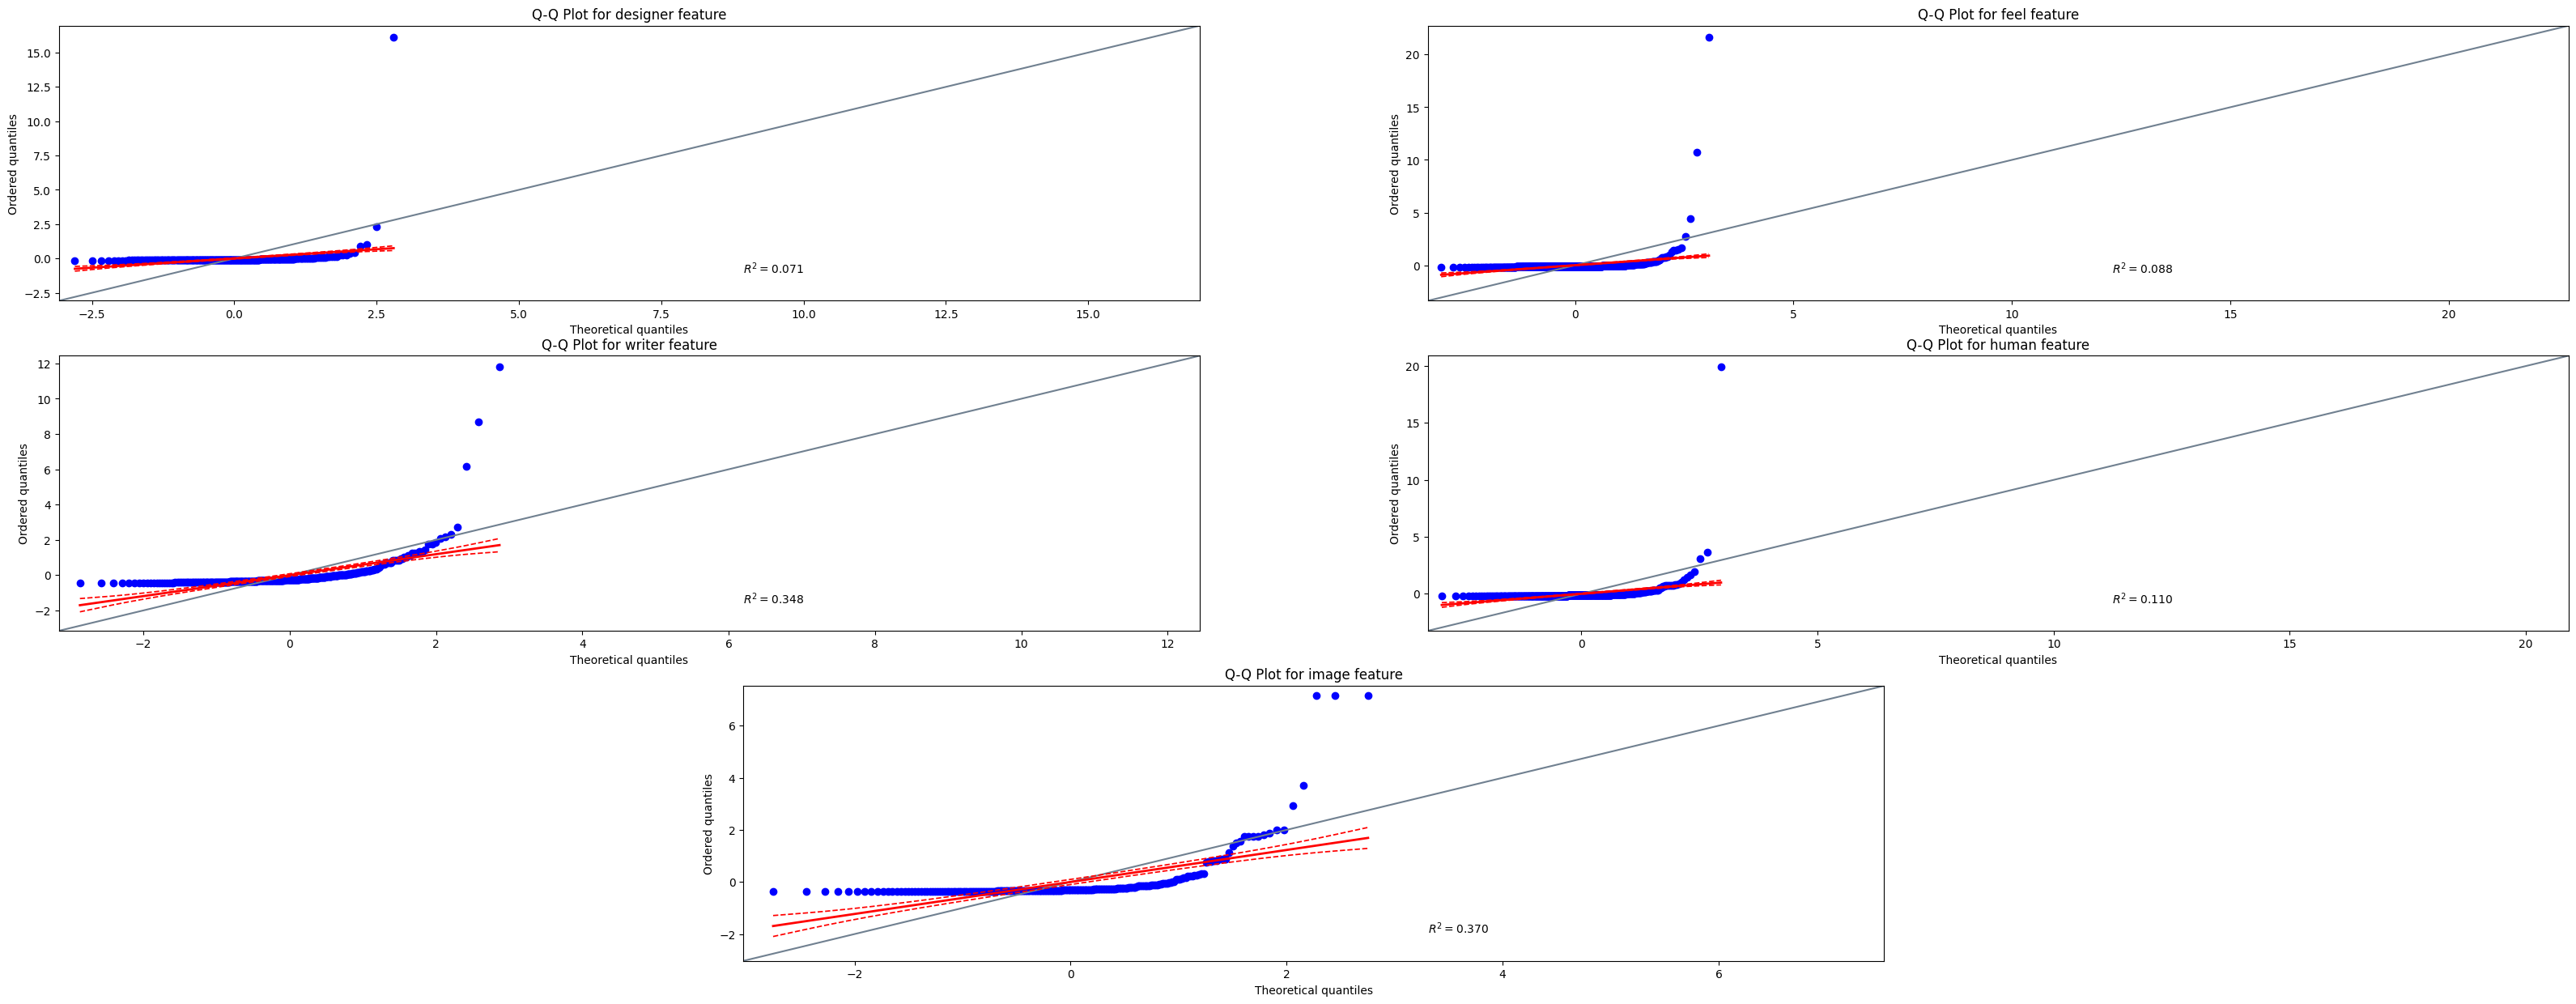

In [392]:

plt.figure(figsize=(40,15))
categories = df_view["key_word_1"].unique()
gs = gridspec.GridSpec(3, 4)
gs.update(wspace=0.5)
ax1 = plt.subplot(gs[0, :2])
ax2 = plt.subplot(gs[0, 2:])
ax3 = plt.subplot(gs[1, :2])
ax4 = plt.subplot(gs[1, 2:])
ax5 = plt.subplot(gs[2, 1:3])

axes = [ax1, ax2, ax3, ax4, ax5]
for ax, cat in zip(axes, categories):
    mask = df_view["key_word_1"] == cat
    sample = df_view.loc[mask, "claps"]
    pg.qqplot(sample, ax=ax)
    ax.set_title(f"Q-Q Plot for {cat} feature")
    ax.grid(False)


In [393]:
pg.homoscedasticity(df_view, dv="log_claps", group="key_word_1")

W          pval  equal_var
levene  20.407446  1.757189e-16      False

In [395]:
pg.pairwise_gameshowell(df_view, dv="log_claps", between="key_word_1")

A       B   mean(A)   mean(B)      diff        se         T  \
0  designer    feel  4.884375  4.877836  0.006539  0.103944  0.062907   
1  designer   human  4.884375  4.230781  0.653594  0.131419  4.973340   
2  designer   image  4.884375  5.304510 -0.420135  0.156450 -2.685424   
3  designer  writer  4.884375  5.040037 -0.155661  0.118451 -1.314142   
4      feel   human  4.877836  4.230781  0.647055  0.117865  5.489791   
5      feel   image  4.877836  5.304510 -0.426673  0.145251 -2.937500   
6      feel  writer  4.877836  5.040037 -0.162200  0.103207 -1.571598   
7     human   image  4.230781  5.304510 -1.073728  0.166025 -6.467261   
8     human  writer  4.230781  5.040037 -0.809255  0.130837 -6.185205   
9     image  writer  5.304510  5.040037  0.264473  0.155961  1.695762   

           df          pval    hedges  
0  561.300702  9.999964e-01  0.004560  
1  711.704977  8.169115e-06  0.382648  
2  405.382540  5.787237e-02 -0.239013  
3  595.773873  6.825222e-01 -0.107234  
4  758.132695  5.468690e-07  0.338822  
5  338.923217  2.893339e-02 -0.224052  
6  684.036604  5.162025e-01 -0.106014  
7  498.401136  2.382826e-09 -0.520730  
8  777.261801  1.000785e-08 -0.446757  
9  412.080861  4.376755e-01  0.144103

It is quite intriguing that key words ``feel`` and ``human`` such statistically significant.

Lets check if linear dependence exists between ``reading_time`` and ``claps``, ``responses`` and ``claps``, ``followers`` and ``claps`` by several test.

In [402]:
sts.pearsonr(df.claps, df.reading_time)

(0.1481507366850105, 1.3422783232153022e-31)

In [403]:
sts.spearmanr(df.claps, df.reading_time)

SpearmanrResult(correlation=0.3369548400426504, pvalue=1.4673025576104546e-163)

In [404]:
sts.kendalltau(df.claps, df.reading_time)

KendalltauResult(correlation=0.2417349768516233, pvalue=3.0945613740397424e-162)

In [405]:
pg.corr(df.claps, df.reading_time, method="bicor")

n         r         CI95%         p-val  power
bicor  6166  0.240193  [0.22, 0.26]  1.221199e-81    1.0

In [409]:
pg.pairwise_corr(df, columns=['claps', "reading_time"], method="shepherd")

X             Y    method alternative     n  outliers        r  \
0  claps  reading_time  shepherd   two-sided  6166     243.0  0.31863   

         CI95%          p-unc  power  
0  [0.3, 0.34]  7.347626e-140    1.0

All tests perfomed with low ``p-value``. It means that we reject the dependence hypothesis.

In [430]:
df_view = df.copy()
df_view["log_claps"] = np.log(df.claps)

In [429]:
sts.pearsonr(df_view.log_claps, df_view.responses)


(0.5325485753965256, 0.0)

In [420]:
sts.spearmanr(df_view.log_claps, df_view.responses)


SpearmanrResult(correlation=0.7481491385038596, pvalue=0.0)

In [418]:
sts.kendalltau(df_view.log_claps, df_view.responses)

KendalltauResult(correlation=0.6024514417773594, pvalue=0.0)

In [421]:
pg.corr(df_view.log_claps, df_view.responses, method="bicor")


n         r         CI95%  p-val  power
bicor  6166  0.471594  [0.45, 0.49]    0.0    1.0

In [422]:
pg.pairwise_corr(df, columns=['log_claps', "responses"], method="shepherd")

X                  Y    method alternative     n  outliers  \
0   responses              index  shepherd   two-sided  6166     137.0   
1   responses          followers  shepherd   two-sided  6166     203.0   
2   responses       reading_time  shepherd   two-sided  6166     294.0   
3   responses            n_words  shepherd   two-sided  6166     288.0   
4   responses      n_code_chunks  shepherd   two-sided  6166     318.0   
5   responses    bold_text_count  shepherd   two-sided  6166     257.0   
6   responses  italic_text_count  shepherd   two-sided  6166     301.0   
7   responses   mean_image_width  shepherd   two-sided  6166     374.0   
8   responses  mean_image_height  shepherd   two-sided  6166     276.0   
9   responses           n_images  shepherd   two-sided  6166     290.0   
10  responses            n_lists  shepherd   two-sided  6166     303.0   
11  responses             n_vids  shepherd   two-sided  6166       NaN   
12  responses            n_links  shepherd   two-sided  6166     299.0   
13  responses              claps  shepherd   two-sided  6166     196.0   
14  responses               year  shepherd   two-sided  6166     318.0   
15  responses              topic  shepherd   two-sided  6166     346.0   
16  responses                ago  shepherd   two-sided  6166     321.0   
17  responses          num_words  shepherd   two-sided  6166     280.0   

           r           CI95%          p-unc     power  
0   0.236127    [0.21, 0.26]   3.577791e-77  1.000000  
1   0.341004    [0.32, 0.36]  2.923869e-162  1.000000  
2   0.272634     [0.25, 0.3]  1.352957e-100  1.000000  
3   0.211905    [0.19, 0.24]   1.169549e-60  1.000000  
4   0.168400    [0.14, 0.19]   1.861922e-38  1.000000  
5   0.205181    [0.18, 0.23]   3.410832e-57  1.000000  
6   0.154494    [0.13, 0.18]   1.174407e-32  1.000000  
7  -0.016049   [-0.04, 0.01]   2.220130e-01  0.230773  
8  -0.030535   [-0.06, -0.0]   1.910504e-02  0.649434  
9   0.242974    [0.22, 0.27]   1.033739e-79  1.000000  
10  0.168882    [0.14, 0.19]   9.148908e-39  1.000000  
11       NaN             NaN            NaN       NaN  
12  0.223640     [0.2, 0.25]   2.096827e-67  1.000000  
13  0.723996    [0.71, 0.74]   0.000000e+00  1.000000  
14 -0.118573  [-0.14, -0.09]   9.224395e-20  1.000000  
15  0.151168    [0.13, 0.18]   4.285331e-31  1.000000  
16  0.135884    [0.11, 0.16]   1.718032e-25  1.000000  
17  0.220252     [0.2, 0.24]   1.369922e-65  1.000000

Same picture

In [437]:
mask = (df.claps > 0) & (df.followers > 0)
df_view = df[mask].copy()
df_view["log_claps"] = np.log(df_view.claps)
df_view["log_followers"] = np.log(df_view.followers)
sts.pearsonr(df_view.log_claps, df_view.log_followers)


(0.42925819147544825, 1.3465428584497375e-264)

In [438]:
sts.spearmanr(df_view.log_claps, df_view.log_followers)

SpearmanrResult(correlation=0.43036835963277964, pvalue=4.175994555547687e-266)

In [439]:
sts.kendalltau(df_view.log_claps, df_view.log_followers)

KendalltauResult(correlation=0.2963239098622532, pvalue=2.448748472554e-255)

In [441]:
pg.pairwise_corr(df_view, columns=['log_claps', "log_followers"], method="shepherd")

X              Y    method alternative     n  outliers        r  \
0  log_claps  log_followers  shepherd   two-sided  5932     360.0  0.43089   

          CI95%          p-unc  power  
0  [0.41, 0.45]  9.537908e-251    1.0

Same reject.

In [504]:
pg.homoscedasticity(df, dv="claps", group="season")

W     pval  equal_var
levene  2.103726  0.09753       True

In [500]:
pg.normality(df, dv="claps", group="season")

W  pval  normal
spring  0.183871   0.0   False
summer  0.202731   0.0   False
fall    0.164782   0.0   False
winter  0.375705   0.0   False

In [501]:
pg.pairwise_gameshowell(df, dv="claps", between="season")

A       B     mean(A)     mean(B)        diff          se         T  \
0    fall  spring  656.295311  864.817553 -208.522243  112.514684 -1.853289   
1    fall  summer  656.295311  933.406040 -277.110730  128.041960 -2.164218   
2    fall  winter  656.295311  787.859606 -131.564295   94.763460 -1.388344   
3  spring  summer  864.817553  933.406040  -68.588487  134.285595 -0.510766   
4  spring  winter  864.817553  787.859606   76.957947  103.043636  0.746848   
5  summer  winter  933.406040  787.859606  145.546434  119.804760  1.214864   

            df      pval    hedges  
0  3449.869204  0.248680 -0.063260  
1  2720.136752  0.133580 -0.078158  
2  2766.706242  0.506753 -0.052939  
3  3046.029617  0.956549 -0.017712  
4  3039.900887  0.878036  0.027464  
5  2303.216361  0.617433  0.046915

We cant say that there is no connection at all. We dont deny the zero hypothesis.